# 3. Streaming application using Spark Structured Streaming (60%)

### Importing required libraries

In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DateType, StringType, FloatType, StructType, StructField
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql import functions as F
from pyspark.sql.types import *
import datetime as dt
from pytz import timezone
from pyspark.sql.functions import isnan, when, count, col
from  pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import concat
from pyspark.sql.functions import lit
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.functions import abs

### 1. SparkSession is created using a SparkConf object, which would use two local cores with a proper application name, and use UTC as the timezone 3 (4%)

In [2]:

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

master = "local[2]"  #specifying 2 local cores
app_name = "Linux memory and process stream Analysis in Spark"
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.session.timeZone", "UTC")  #UTC timezone



spark = SparkSession \
    .builder \
    .config(conf=spark_conf)\
    .appName(app_name) \
    .getOrCreate()
    


sc = spark.sparkContext


sc.setLogLevel('ERROR')

### 2. From the Kafka producers in Task 1.1 and 1.2, ingest the streaming data into Spark Streaming for both process and memory activities(3%)

In [3]:
process_topic = "Streaming_Linux_process"
df_process = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", process_topic) \
    .load()



memory_topic = "Streaming_Linux_memory"
df_memory = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", memory_topic) \
    .load()

### Here i am ingesting the streaming data into Spark Streaming for both process and memory activities.

### Converting the key/value from the kafka data stream to string

In [4]:
df_process = df_process.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")
df_memory = df_memory.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [5]:
df_process.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: string (nullable = true)



In [6]:
df_memory.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: string (nullable = true)



### Defining the Schema and Parsing the data

In [7]:
schema_process = ArrayType(StructType([    
    StructField('sequence', StringType(), True), 
    StructField('machine', StringType(), True),
    StructField('PID', StringType(), True),
    StructField('TRUN', StringType(), True),
    StructField('TSLPI', StringType(), True),
    StructField('TSLPU', StringType(), True),
    StructField('POLI', StringType(), True),
    StructField('NICE', StringType(), True),
    StructField('PRI', StringType(), True),
    StructField('RTPR', StringType(), True),
    StructField('CPUNR', StringType(), True),
    StructField('Status', StringType(), True),
    StructField('EXC', StringType(), True),
    StructField('State', StringType(), True),
    StructField('CPU', StringType(), True),
    StructField('CMD', StringType(), True),
    StructField('ts', StringType(), True)
    
]))


schema_memory = ArrayType(StructType([    
    StructField('sequence', StringType(), True), 
    StructField('machine', StringType(), True),
    StructField('PID', StringType(), True),
    StructField('MINFLT', StringType(), True),
    StructField('MAJFLT', StringType(), True),
    StructField('VSTEXT', StringType(), True),
    StructField('VSIZE', StringType(), True),
    StructField('RSIZE', StringType(), True),
    StructField('VGROW', StringType(), True),
    StructField('RGROW', StringType(), True),
    StructField('MEM', StringType(), True),
    StructField('CMD', StringType(), True),
    StructField('ts', StringType(), True)
    
    
]))

### Parsing the string to the json format based on the defined schema for both process and memory

In [8]:
df_process=df_process.select(F.from_json(F.col("value").cast("string"), schema_process).alias('parsed_value'))
df_memory=df_memory.select(F.from_json(F.col("value").cast("string"), schema_memory).alias('parsed_value'))

In [9]:
df_process.printSchema()

root
 |-- parsed_value: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- sequence: string (nullable = true)
 |    |    |-- machine: string (nullable = true)
 |    |    |-- PID: string (nullable = true)
 |    |    |-- TRUN: string (nullable = true)
 |    |    |-- TSLPI: string (nullable = true)
 |    |    |-- TSLPU: string (nullable = true)
 |    |    |-- POLI: string (nullable = true)
 |    |    |-- NICE: string (nullable = true)
 |    |    |-- PRI: string (nullable = true)
 |    |    |-- RTPR: string (nullable = true)
 |    |    |-- CPUNR: string (nullable = true)
 |    |    |-- Status: string (nullable = true)
 |    |    |-- EXC: string (nullable = true)
 |    |    |-- State: string (nullable = true)
 |    |    |-- CPU: string (nullable = true)
 |    |    |-- CMD: string (nullable = true)
 |    |    |-- ts: string (nullable = true)



In [10]:
df_memory.printSchema()

root
 |-- parsed_value: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- sequence: string (nullable = true)
 |    |    |-- machine: string (nullable = true)
 |    |    |-- PID: string (nullable = true)
 |    |    |-- MINFLT: string (nullable = true)
 |    |    |-- MAJFLT: string (nullable = true)
 |    |    |-- VSTEXT: string (nullable = true)
 |    |    |-- VSIZE: string (nullable = true)
 |    |    |-- RSIZE: string (nullable = true)
 |    |    |-- VGROW: string (nullable = true)
 |    |    |-- RGROW: string (nullable = true)
 |    |    |-- MEM: string (nullable = true)
 |    |    |-- CMD: string (nullable = true)
 |    |    |-- ts: string (nullable = true)



### Flatenning

In [11]:
df_process = df_process.select(F.explode(F.col("parsed_value")).alias('unnested_value')) 
df_memory = df_memory.select(F.explode(F.col("parsed_value")).alias('unnested_value')) 

### Renaming columns appropriately

In [12]:
df_process_formatted = df_process.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.TRUN").alias("TRUN"),
                    F.col("unnested_value.TSLPI").alias("TSLPI"),
                    F.col("unnested_value.TSLPU").alias("TSLPU"),
                    F.col("unnested_value.POLI").alias("POLI"),
                    F.col("unnested_value.NICE").alias("NICE"),
                    F.col("unnested_value.PRI").alias("PRI"),
                    F.col("unnested_value.RTPR").alias("RTPR"),
                    F.col("unnested_value.CPUNR").alias("CPUNR"),
                    F.col("unnested_value.Status").alias("Status"),
                    F.col("unnested_value.EXC").alias("EXC"),
                    F.col("unnested_value.State").alias("State"),
                    F.col("unnested_value.CPU").alias("CPU"),
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
    
                )


df_memory_formatted = df_memory.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.MINFLT").alias("MINFLT"),
                    F.col("unnested_value.MAJFLT").alias("MAJFLT"),
                    F.col("unnested_value.VSTEXT").alias("VSTEXT"),
                    F.col("unnested_value.VSIZE").alias("VSIZE"),
                    F.col("unnested_value.RSIZE").alias("RSIZE"),
                    F.col("unnested_value.VGROW").alias("VGROW"),
                    F.col("unnested_value.RGROW").alias("RGROW"),
                    F.col("unnested_value.MEM").alias("MEM"),
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
    
                )

In [13]:
df_process_formatted.printSchema()

root
 |-- sequence: string (nullable = true)
 |-- machine: string (nullable = true)
 |-- PID: string (nullable = true)
 |-- TRUN: string (nullable = true)
 |-- TSLPI: string (nullable = true)
 |-- TSLPU: string (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: string (nullable = true)
 |-- PRI: string (nullable = true)
 |-- RTPR: string (nullable = true)
 |-- CPUNR: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: string (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: string (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: string (nullable = true)



In [14]:
df_memory_formatted.printSchema()

root
 |-- sequence: string (nullable = true)
 |-- machine: string (nullable = true)
 |-- PID: string (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: string (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: string (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: string (nullable = true)



### 3. Then the streaming data format should be transformed into the proper formats following the metadata file schema for both process and memory, similar to assignment 2A 4 (3%)

### Restoring NICE value based on PRI value

In [15]:
df_process_formatted = df_process_formatted.withColumn("NICE", df_process_formatted["NICE"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("PRI", df_process_formatted["PRI"].cast(IntegerType()))

df_process_formatted = df_process_formatted.withColumn('NICE',when((col('PRI') >= 100) & (col('PRI') <= 119)\
                                  ,col('NICE')*-1 ).otherwise(col("NICE")))

### numeric values with extra spaces or “K” / “M” / “G” are properly transformed into their correct values

In [16]:
# memory data
from  pyspark.sql.functions import regexp_replace

df_memory_formatted = df_memory_formatted.withColumn("MINFLT", regexp_replace("MINFLT", "K", "000"))
df_memory_formatted = df_memory_formatted.withColumn("MAJFLT", regexp_replace("MAJFLT", "224.2M", "224200000"))
df_memory_formatted = df_memory_formatted.withColumn("MAJFLT", regexp_replace("MAJFLT", "224.4M", "224400000"))
df_memory_formatted = df_memory_formatted.withColumn("VSTEXT", regexp_replace("VSTEXT", "K", "000"))
df_memory_formatted = df_memory_formatted.withColumn("RSIZE", regexp_replace("RSIZE", "K", "000"))
df_memory_formatted = df_memory_formatted.withColumn("RSIZE", regexp_replace("RSIZE", "224.2M", "224200000"))
df_memory_formatted = df_memory_formatted.withColumn("RSIZE", regexp_replace("RSIZE", "224.4M", "224400000"))
df_memory_formatted = df_memory_formatted.withColumn("VGROW", regexp_replace("VGROW", " ", ""))
df_memory_formatted = df_memory_formatted.withColumn("VGROW", regexp_replace("VGROW", "K", "000"))
df_memory_formatted = df_memory_formatted.withColumn("RGROW", regexp_replace("RGROW", "0K", "000"))



### 4. For process and memory, respectively, create a new column “CMD_PID” concatenating “CMD” and “PID” columns, and a new column “event_time” as timestamp format based on the unix time in “ts” column (5%)

## new column “CMD_PID” concatenating “CMD” and “PID” columns

In [17]:
from pyspark.sql.functions import concat
column_list = ['CMD','PID']
df_memory_formatted = df_memory_formatted.withColumn('CMD_PID',concat(*column_list))
df_process_formatted = df_process_formatted.withColumn('CMD_PID',concat(*column_list))

### Recasting data types and appending ts to event time and Water marking for 20 secs

In [18]:
#For process
df_process_formatted = df_process_formatted.withColumn("sequence", df_process_formatted["sequence"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("machine", df_process_formatted["machine"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("PID", df_process_formatted["PID"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("TRUN", df_process_formatted["TRUN"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("TSLPI", df_process_formatted["TSLPI"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("TSLPU", df_process_formatted["TSLPU"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("POLI", df_process_formatted["POLI"].cast(StringType()))
df_process_formatted = df_process_formatted.withColumn("NICE", df_process_formatted["NICE"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("PRI", df_process_formatted["PRI"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("RTPR", df_process_formatted["RTPR"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("CPUNR", df_process_formatted["CPUNR"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("Status", df_process_formatted["Status"].cast(StringType()))
df_process_formatted = df_process_formatted.withColumn("EXC", df_process_formatted["EXC"].cast(IntegerType()))
df_process_formatted = df_process_formatted.withColumn("State", df_process_formatted["State"].cast(StringType()))
df_process_formatted = df_process_formatted.withColumn("CPU", df_process_formatted["CPU"].cast(FloatType()))
df_process_formatted = df_process_formatted.withColumn("CMD", df_process_formatted["CMD"].cast(StringType()))
df_process_formatted = df_process_formatted.withColumn("ts", df_process_formatted["ts"].cast(IntegerType()))

# Creating event time
df_process_formatted = df_process_formatted.withColumn('event_time', lit(None).cast(TimestampType()))

# Appending ts to event time and Water marking for 20 secs
df_process_formatted = df_process_formatted.withWatermark("event_time", "20 seconds")\
.withColumn('event_time', df_process_formatted["ts"].cast(TimestampType()))

df_process_formatted = df_process_formatted.withColumn("CMD_PID", df_process_formatted["CMD_PID"].cast(StringType()))

#For memory

df_memory_formatted = df_memory_formatted.withColumn("sequence", df_memory_formatted["sequence"].cast(IntegerType()))
df_memory_formatted = df_memory_formatted.withColumn("machine", df_memory_formatted["machine"].cast(IntegerType()))
df_memory_formatted = df_memory_formatted.withColumn("PID", df_memory_formatted["PID"].cast(IntegerType()))
df_memory_formatted = df_memory_formatted.withColumn("MINFLT", df_memory_formatted["MINFLT"].cast(FloatType()))
df_memory_formatted = df_memory_formatted.withColumn("MAJFLT", df_memory_formatted["MAJFLT"].cast(FloatType()))
df_memory_formatted = df_memory_formatted.withColumn("VSTEXT", df_memory_formatted["VSTEXT"].cast(FloatType()))
df_memory_formatted = df_memory_formatted.withColumn("VSIZE", df_memory_formatted["VSIZE"].cast(FloatType()))
df_memory_formatted = df_memory_formatted.withColumn("RSIZE", df_memory_formatted["RSIZE"].cast(FloatType()))
df_memory_formatted = df_memory_formatted.withColumn("VGROW", df_memory_formatted["VGROW"].cast(FloatType()))
df_memory_formatted = df_memory_formatted.withColumn("RGROW", df_memory_formatted["RGROW"].cast(FloatType()))
df_memory_formatted = df_memory_formatted.withColumn("MEM", df_memory_formatted["MEM"].cast(FloatType()))
df_memory_formatted = df_memory_formatted.withColumn("CMD", df_memory_formatted["CMD"].cast(StringType()))
df_memory_formatted = df_memory_formatted.withColumn("ts", df_memory_formatted["ts"].cast(IntegerType()))

df_memory_formatted = df_memory_formatted.withColumn("CMD_PID", df_memory_formatted["CMD_PID"].cast(StringType()))

# Creating event time
df_memory_formatted = df_memory_formatted.withColumn('event_time', lit(None).cast(TimestampType()))

# Appending ts to event time and Water marking for 20 secs

df_memory_formatted = df_memory_formatted.withWatermark("event_time", "20 seconds")\
.withColumn('event_time', df_memory_formatted["ts"].cast(TimestampType()))

### 5. Persist the transformed streaming data in parquet format for both process and memory (5%)

### Write stream output to a parquet file

In [19]:
# Write into parquet files the unsuccessful requests partitioned by status code
process_query_file_sink = df_process_formatted.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "process.parquet")\
        .option("checkpointLocation", "process.parquet/checkpoint")\
        .start()

In [20]:
# Write into parquet files the unsuccessful requests partitioned by status code
memory_query_file_sink = df_memory_formatted.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "memory.parquet")\
        .option("checkpointLocation", "memory.parquet/checkpoint")\
        .start()

### 6. Load the machine learning models given 6 , and use the models to predict whether each process or memory streaming record is an attack event, respectively (5%)

In [21]:
#Loading the Pipeline Model From the filesystem
from pyspark.ml import PipelineModel

process_pipelineModel = PipelineModel.load('process_pipeline_model')


memory_pipelineModel = PipelineModel.load('memory_pipeline_model')

In [22]:
print(process_pipelineModel.stages[-1]._java_obj.paramMap())

{
	GBTClassifier_05c24908a907-featuresCol: scaled_features,
	GBTClassifier_05c24908a907-labelCol: attack,
	GBTClassifier_05c24908a907-predictionCol: prediction
}


In [23]:
print(memory_pipelineModel.stages[-1]._java_obj.paramMap())

{
	GBTClassifier_05c24908a907-featuresCol: scaled_features,
	GBTClassifier_05c24908a907-labelCol: attack,
	GBTClassifier_05c24908a907-predictionCol: prediction
}


In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### generating prediction dataframes for both memory and process using the formatted data frames

In [25]:
process_predictions =  process_pipelineModel.transform(df_process_formatted)
memory_predictions =  memory_pipelineModel.transform(df_memory_formatted)

In [26]:
# query_process_predictions = process_predictions \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [27]:
# selection = memory_predictions.select("features","probability", "prediction")
# selection.show(truncate=False)

In [28]:
# query_memory_predictions = memory_predictions \
#     .writeStream \
#     .outputMode("append") \
#     .format("memory") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [29]:
from pyspark.sql.functions import *

### 7. Using the prediction result, and monitor the data following the requirements below (30%)

### Part 7a for both process and memory done below

## for process

### filtering where attack is 1, grouping by the window and machine, getting distinct counts of CMD_PID, selecting machine window and count, finally sorting by window

In [30]:
# for process
process_2_min_window_counts = process_predictions.filter(process_predictions['prediction']==1.0)\
.groupBy((window(process_predictions.event_time, "120 seconds")), "machine")\
.agg(F.approx_count_distinct("CMD_PID").alias("count"))\
.select('machine', 'window', 'count')\
.sort('window')



#### Query and store in memory

In [31]:
# process_2_min_window_counts.show(truncate=False)
query_process_predictions = process_2_min_window_counts \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("query_process_predictions_xx") \
    .trigger(processingTime='5 seconds') \
    .start()

In [32]:
# query_process_predictions.stop()

## for memory

### filtering where attack is 1, grouping by the window and machine, getting distinct counts of CMD_PID, selecting machine window and count, finally sorting by window

In [33]:
# for memory

memory_2_min_window_counts = memory_predictions.filter(memory_predictions['prediction']==1)\
.groupBy((window(memory_predictions.event_time, "120 seconds")), "machine")\
.agg(F.approx_count_distinct("CMD_PID").alias("count"))\
.select('machine', 'window', 'count')\
.sort('window')

#### Query and store in memory


In [34]:

query_memory_predictions = memory_2_min_window_counts \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("query_memory_predictions_xx") \
    .trigger(processingTime='5 seconds') \
    .start()

In [35]:
# query_memory_predictions.stop()

### 8. Visualise the data in line charts for step 7a (5%)








### This part of the visualization taken 10 mins after running the producer file, as it only starts plotting after recieving 10 minute of data(5 blocks of 2 minute windows)

#### need to stop plotting this (using keyboard interrupt) before plotting the memory

## plotting for process predictions

<IPython.core.display.Javascript object>


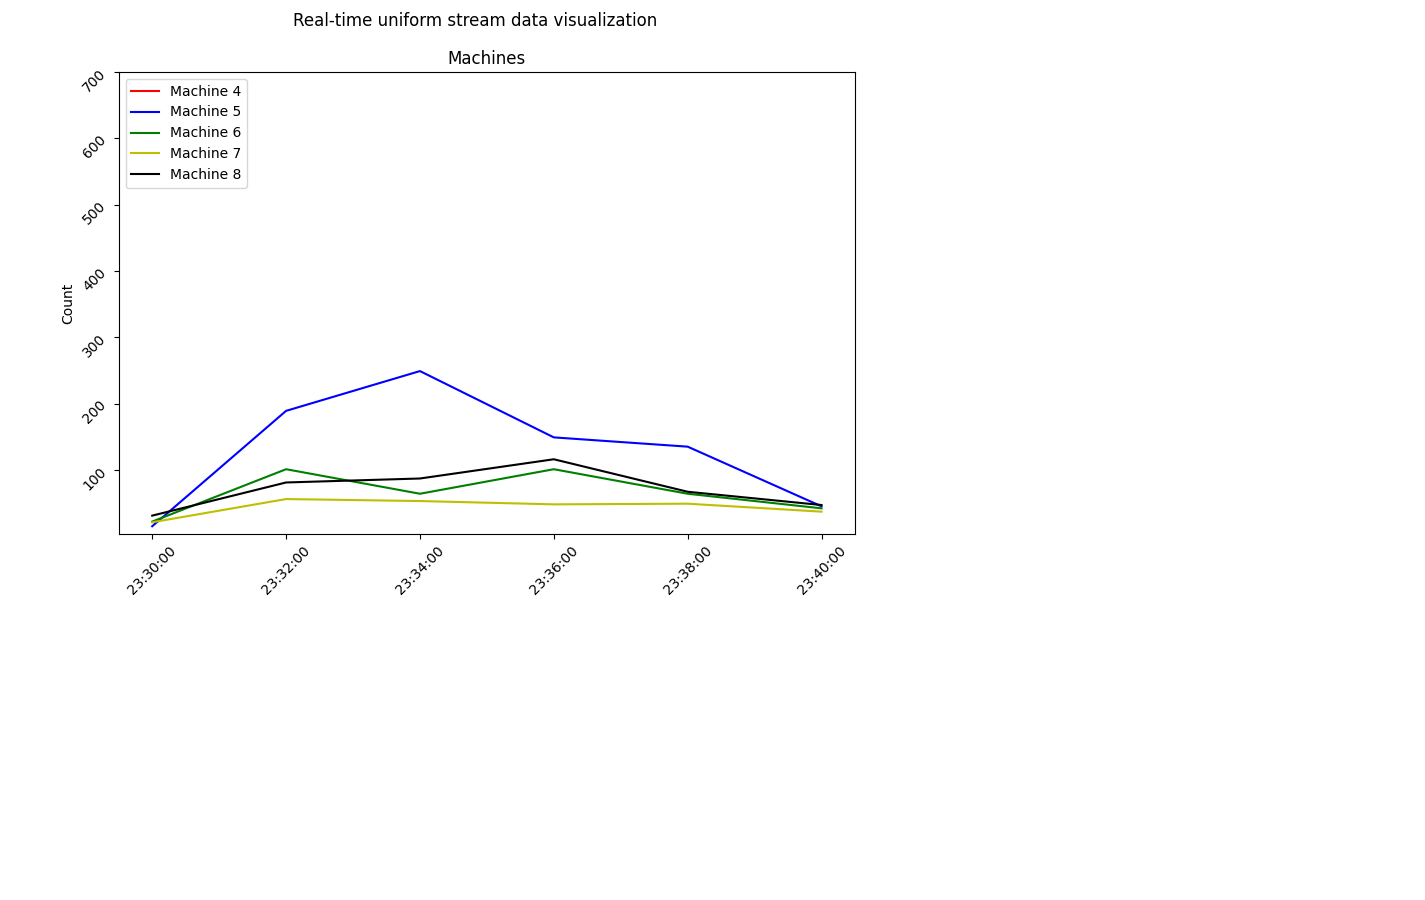

[] ['23:30:00'] [] [] []
[] [15] [] [] []
[] ['23:30:00'] ['23:30:00'] [] []
[] [15] [22] [] []
[] ['23:30:00'] ['23:30:00'] ['23:30:00'] []
[] [15] [22] [21] []
[] ['23:30:00'] ['23:30:00'] ['23:30:00'] ['23:30:00']
[] [15] [22] [21] [31]
[] ['23:30:00', '23:32:00'] ['23:30:00'] ['23:30:00'] ['23:30:00']
[] [15, 20] [22] [21] [31]
[] ['23:30:00', '23:32:00'] ['23:30:00', '23:32:00'] ['23:30:00'] ['23:30:00']
[] [15, 20] [22, 26] [21] [31]
[] ['23:30:00', '23:32:00'] ['23:30:00', '23:32:00'] ['23:30:00', '23:32:00'] ['23:30:00']
[] [15, 20] [22, 26] [21, 14] [31]
[] ['23:30:00', '23:32:00'] ['23:30:00', '23:32:00'] ['23:30:00', '23:32:00'] ['23:30:00', '23:32:00']
[] [15, 20] [22, 26] [21, 14] [31, 20]
[] ['23:30:00'] [] [] []
[] [15] [] [] []
[] ['23:30:00'] ['23:30:00'] [] []
[] [15] [22] [] []
[] ['23:30:00'] ['23:30:00'] ['23:30:00'] []
[] [15] [22] [21] []
[] ['23:30:00'] ['23:30:00'] ['23:30:00'] ['23:30:00']
[] [15] [22] [21] [31]
[] ['23:30:00', '23:32:00'] ['23:30:00'] ['23:30

KeyboardInterrupt: 

In [36]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.title.set_text('Time Vs Value')
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots()

while True:
    proc_df = spark.sql("select * from query_process_predictions_xx order by window,machine")\
    .toPandas()

    
    xtime4,xtime5,xtime6,xtime7,xtime8 = [],[],[],[],[]
    count4,count5, count6, count7, count8 = [], [], [], [],[]
    
    proc_df['times'] = ""
    for z in range(len(proc_df)):
        proc_df.iloc[z,3] = proc_df['window'][z][1].strftime("%X")
        
        
    for i in range(len(proc_df)):
        if proc_df['machine'][i] == 4:
            xtime4.append(proc_df['times'][i])
            count4.append(proc_df['count'][i])
            
        elif proc_df['machine'][i] == 5:
            xtime5.append(proc_df['times'][i])
            count5.append(proc_df['count'][i])

        elif proc_df['machine'][i] == 6:
            xtime6.append(proc_df['times'][i])
            count6.append(proc_df['count'][i])

        elif proc_df['machine'][i] == 7:
            xtime7.append(proc_df['times'][i])
            count7.append(proc_df['count'][i])

        elif proc_df['machine'][i] ==8:
            xtime8.append(proc_df['times'][i])
            count8.append(proc_df['count'][i]) 
            
        
        # printing to see how the values are appended in the empty list
        print(xtime4,xtime5,xtime6,xtime7,xtime8)
        print(count4,count5, count6, count7, count8)
        if len(count8)>5:


            ax.clear()
            ax.plot(xtime4, count4, color='r',label="Machine 4")
            ax.plot(xtime5, count5, color='b',label="Machine 5")
            ax.plot(xtime6, count6, color='g',label="Machine 6")
            ax.plot(xtime7, count7, color='y',label="Machine 7")
            ax.plot(xtime8, count8, color='black',label="Machine 8")
            ax.legend(loc="upper left")
            ax.set_title("Machines")
            ax.set_xlabel("Time")
            ax.set_ylabel("Count")
            ax.set_yticks([100,200,300,400,500,600,700])
            ax.tick_params(labelrotation=45)
            fig.canvas.draw()


    
            if len(xtime4) == 0:
                pass
            else:
                xtime4.pop(0)
                
                
            if len(xtime5) == 0:
                pass
            else:
                xtime5.pop(0)
                
 
            if len(xtime6) == 0:
                pass
            else:
                xtime6.pop(0)
            
           
            if len(xtime7) == 0:
                pass
            else:
                xtime7.pop(0)
        
        
            if len(xtime8) == 0:
                pass
            else:
                xtime8.pop(0)
            

            if len(count4) == 0:
                pass
            else:
                count4.pop(0)
                
            if len(count5) == 0:
                pass
            else:
                count5.pop(0)
                
            if len(count6) == 0:
                pass
            else:
                count6.pop(0)
                
            if len(count7) == 0:
                pass
            else:
                count7.pop(0)
                
            if len(count8) == 0:
                pass
            else:
                count8.pop(0)
            
           



#### 8. Visualise the data in line charts for step 7a (5%)



### This part of the visualization taken 10 mins after running the producer file, as it only starts plotting after recieving 10 minute of data(5 blocks of 2 minute windows)

# plotting for memory predictions

<IPython.core.display.Javascript object>


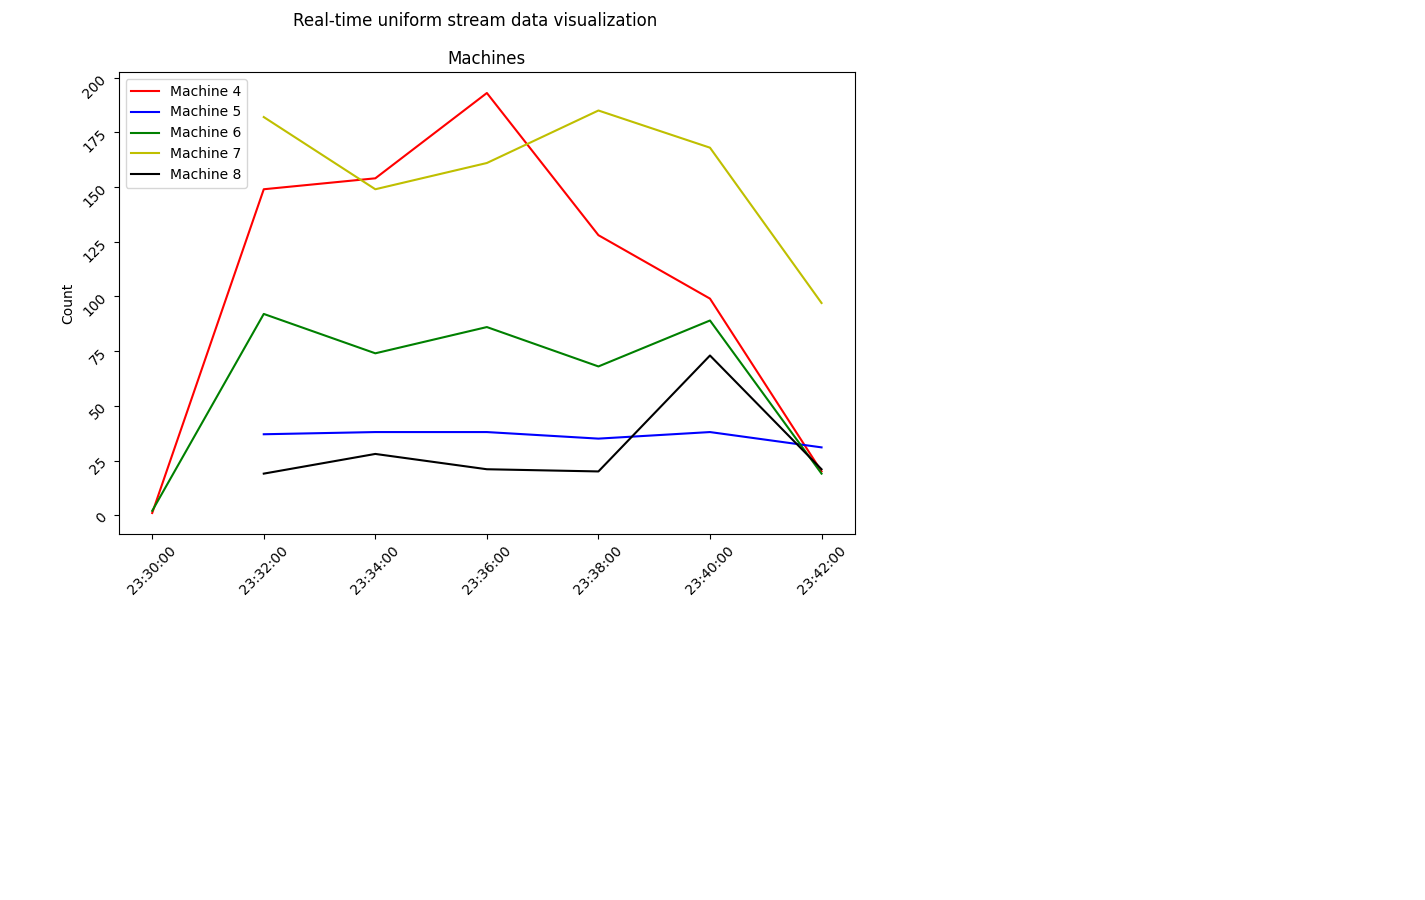

['23:30:00'] [] [] [] []
[1] [] [] [] []
['23:30:00'] [] ['23:30:00'] [] []
[1] [] [2] [] []
['23:30:00', '23:32:00'] [] ['23:30:00'] [] []
[1, 149] [] [2] [] []
['23:30:00', '23:32:00'] ['23:32:00'] ['23:30:00'] [] []
[1, 149] [37] [2] [] []
['23:30:00', '23:32:00'] ['23:32:00'] ['23:30:00', '23:32:00'] [] []
[1, 149] [37] [2, 92] [] []
['23:30:00', '23:32:00'] ['23:32:00'] ['23:30:00', '23:32:00'] ['23:32:00'] []
[1, 149] [37] [2, 92] [182] []
['23:30:00', '23:32:00'] ['23:32:00'] ['23:30:00', '23:32:00'] ['23:32:00'] ['23:32:00']
[1, 149] [37] [2, 92] [182] [19]
['23:30:00', '23:32:00', '23:34:00'] ['23:32:00'] ['23:30:00', '23:32:00'] ['23:32:00'] ['23:32:00']
[1, 149, 154] [37] [2, 92] [182] [19]
['23:30:00', '23:32:00', '23:34:00'] ['23:32:00', '23:34:00'] ['23:30:00', '23:32:00'] ['23:32:00'] ['23:32:00']
[1, 149, 154] [37, 38] [2, 92] [182] [19]
['23:30:00', '23:32:00', '23:34:00'] ['23:32:00', '23:34:00'] ['23:30:00', '23:32:00', '23:34:00'] ['23:32:00'] ['23:32:00']
[1, 149, 

KeyboardInterrupt: 

In [37]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.title.set_text('Time Vs Value')
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots()

while True:
    memory_df = spark.sql("select * from query_memory_predictions_xx order by window,machine")\
    .toPandas()
    
    mem_xtime4,mem_xtime5,mem_xtime6,mem_xtime7,mem_xtime8 = [],[],[],[],[]
    mem_count4,mem_count5, mem_count6, mem_count7, mem_count8 = [], [], [], [], []
    
    memory_df['times'] = ""
    for z in range(len(memory_df)):
        memory_df.iloc[z,3] = memory_df['window'][z][1].strftime("%X")
        
        
    for i in range(len(memory_df)):
        if memory_df['machine'][i] == 4:
            mem_xtime4.append(memory_df['times'][i])
            mem_count4.append(memory_df['count'][i])
        
        elif memory_df['machine'][i] == 5:
            mem_xtime5.append(memory_df['times'][i])
            mem_count5.append(memory_df['count'][i])

        elif memory_df['machine'][i] == 6:
            mem_xtime6.append(memory_df['times'][i])
            mem_count6.append(memory_df['count'][i])

        elif memory_df['machine'][i] == 7:
            mem_xtime7.append(memory_df['times'][i])
            mem_count7.append(memory_df['count'][i])

        elif memory_df['machine'][i] ==8:
            mem_xtime8.append(memory_df['times'][i])
            mem_count8.append(memory_df['count'][i]) 
            
        
        # printing to see how the values are appended in the empty list
        print(mem_xtime4,mem_xtime5,mem_xtime6,mem_xtime7,mem_xtime8)
        print(mem_count4,mem_count5, mem_count6, mem_count7, mem_count8)
        if len(mem_count8)>5:


            ax.clear()
            ax.plot(mem_xtime4, mem_count4, color='r',label="Machine 4")
            ax.plot(mem_xtime5, mem_count5, color='b',label="Machine 5")
            ax.plot(mem_xtime6, mem_count6, color='g',label="Machine 6")
            ax.plot(mem_xtime7, mem_count7, color='y',label="Machine 7")
            ax.plot(mem_xtime8, mem_count8, color='black',label="Machine 8")
            ax.legend(loc="upper left")
            ax.set_title("Machines")
            ax.set_xlabel("Time")
            ax.set_ylabel("Count")
            #ax.set_yticks([100,200,300,400])
            ax.tick_params(labelrotation=45)
            fig.canvas.draw()


            if len(mem_xtime4) == 0:
                pass
            else:
                mem_xtime4.pop(0)
                
                
            if len(mem_xtime5) == 0:
                pass
            else:
                mem_xtime5.pop(0)
                
 
            if len(mem_xtime6) == 0:
                pass
            else:
                mem_xtime6.pop(0)
            
           
            if len(mem_xtime7) == 0:
                pass
            else:
                mem_xtime7.pop(0)
        
        
            if len(mem_xtime8) == 0:
                pass
            else:
                mem_xtime8.pop(0)
            

            if len(mem_count4) == 0:
                pass
            else:
                mem_count4.pop(0)
                
            if len(mem_count5) == 0:
                pass
            else:
                mem_count5.pop(0)
                
            if len(mem_count6) == 0:
                pass
            else:
                mem_count6.pop(0)
                
            if len(mem_count7) == 0:
                pass
            else:
                mem_count7.pop(0)
                
            if len(mem_count8) == 0:
                pass
            else:
                mem_count8.pop(0)


## part 7 B

In [38]:
process_predictions1=process_predictions.filter(process_predictions['prediction']==1.0)

#renaming process timestamp
process_predictions1 = process_predictions1.withColumnRenamed('ts', 'process_ts')

memory_predictions1=memory_predictions.filter(memory_predictions['prediction']==1.0)

#renaming memory timestamp
memory_predictions1 = memory_predictions1.withColumnRenamed('ts', 'memory_ts')

inner_join_df = process_predictions1.join(memory_predictions1, (process_predictions1.machine == memory_predictions1.machine) &
                                        (process_predictions1.CMD_PID == memory_predictions1.CMD_PID), "inner")


inner_join_df = inner_join_df.withColumn('processing_time', lit(None).cast(TimestampType()))

# input processing time
inner_join_df=inner_join_df.withColumn('processing_time',current_timestamp())

# 30 sec diff

# a new column with the process and memory time differnce
inner_join_df = inner_join_df.withColumn("time_difference",
                                         abs(inner_join_df.process_ts -inner_join_df.memory_ts))


# filterting out where the time difference is less than 30 secs
inner_join_df = inner_join_df.filter(inner_join_df.time_difference<30)

## Steps

    1. Filtering the process and memory predictions
    2. renaming the ts column in both memory and process which is used to find time difference later
    3. implementing an inner join on process and memory dataframes matching keys for machine id and CMD_PID
    4. creating empty column named processing_time
    5. filling processing_time with current timestamp (timestamp while processing)
    6. creating a time_difference column and appending the absolute difference in process and memory event_times
    7. filtering out the dataframe where time_difference is less than 30 as per requirement.

In [39]:
inner_join_df.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- process_ts: integer (nullable = true)
 |-- CMD_PID: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- POLI_idx: double (nullable = false)
 |-- Status_idx: double (nullable = false)
 |-- State_idx: double (nullable = false)
 |-- POLI_vec: vector (nullable = true)
 |-- Status_vec: vector (nullable = true)
 |-- State_vec: vector (nullable = true)
 |-- tmp_CMD: array (null

In [40]:
from pyspark.sql.functions import abs

In [41]:
query_join_predictions = inner_join_df \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .queryName("query_join_predictions_xx") \
    .trigger(processingTime='5 seconds') \
    .start()

In [42]:
query_join_predictions.stop()

### Persisting 7B in parquet

In [43]:
process_memory_attack_query_file_sink = inner_join_df.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "process_memory_attack.parquet")\
        .option("checkpointLocation", "process_memory_attack.parquet/checkpoint")\
        .start()

#### if need to stop the parquet filing

In [ ]:
# process_memory_attack_query_file_sink.stop()